In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from tqdm import tqdm
import librosa as lb
import warnings
warnings.filterwarnings('ignore')  
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
from sklearn import metrics
from sklearn.metrics import accuracy_score

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Plot feature extraction function

In [ ]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,30))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names') 

# Dataset

In [ ]:
wifi_train=pd.read_csv("/content/drive/MyDrive/SHL 2021/Train/WiFi/WiFi with Label.csv",low_memory=False)
wifi_train.head(2)

,Epoch time[ms],N,B1,S1,R1,F1,C1,B2,S2,R2,F2,C2,B3,S3,R3,F3,C3,B4,S4,R4,F4,C4,B5,S5,R5,F5,C5,B6,S6,R6,F6,C6,B7,S7,R7,F7,C7,B8,S8,R8,...,S126,R126,F126,C126,B127,S127,R127,F127,C127,B128,S128,R128,F128,C128,B129,S129,R129,F129,C129,B130,S130,R130,F130,C130,B131,S131,R131,F131,C131,B132,S132,R132,F132,C132,B133,S133,R133,F133,C133,Label
0,1490431583458,6,c0:05:c2:29:40:ff,VM8236218,-43.0,5220.0,[WPA2-PSK-CCMP+TKIP][WPS][ESS],c0:05:c2:29:40:f9,VM8236218,-48.0,2412.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],d2:05:c2:29:40:f9,Virgin Media,-48.0,2412.0,[WPA2-EAP-CCMP][ESS],90:f6:52:f5:b8:90,TP-LINK_F5B890,-64.0,2452.0,[WPA-PSK-CCMP][WPA2-PSK-CCMP][WPS][ESS],98:e7:f5:b9:3f:14,TALKTALKB93F0E,-71.0,2432.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],30:91:8f:06:47:c9,PlusnetWireless0647C9,-90.0,2462.0,[WPA-PSK-TKIP][WPA2-PSK-CCMP][WPS][ESS],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,1490431584461,6,c0:05:c2:29:40:ff,VM8236218,-43.0,5220.0,[WPA2-PSK-CCMP+TKIP][WPS][ESS],c0:05:c2:29:40:f9,VM8236218,-48.0,2412.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],d2:05:c2:29:40:f9,Virgin Media,-48.0,2412.0,[WPA2-EAP-CCMP][ESS],90:f6:52:f5:b8:90,TP-LINK_F5B890,-64.0,2452.0,[WPA-PSK-CCMP][WPA2-PSK-CCMP][WPS][ESS],98:e7:f5:b9:3f:14,TALKTALKB93F0E,-71.0,2432.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],30:91:8f:06:47:c9,PlusnetWireless0647C9,-90.0,2462.0,[WPA-PSK-TKIP][WPA2-PSK-CCMP][WPS][ESS],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [ ]:
wifi_val=pd.read_csv("/content/drive/MyDrive/SHL 2021/Validate/WiFi/WiFi with Label.csv",low_memory=False)
wifi_val.drop(["I1","I2"],axis=1,inplace=True)
wifi_val.head(2)

,Epoch time[ms],N,B1,S1,R1,F1,C1,B2,S2,R2,F2,C2,B3,S3,R3,F3,C3,B4,S4,R4,F4,C4,B5,S5,R5,F5,C5,B6,S6,R6,F6,C6,B7,S7,R7,F7,C7,B8,S8,R8,...,S68,R68,F68,C68,B69,S69,R69,F69,C69,B70,S70,R70,F70,C70,B71,S71,R71,F71,C71,B72,S72,R72,F72,C72,B73,S73,R73,F73,C73,B74,S74,R74,F74,C74,B75,S75,R75,F75,C75,Label
0,1497427493997,11,70:50:af:2d:ed:d9,SKY484B1,-37.0,2462.0,[WPA2-PSK-CCMP][WPS][ESS],74:44:01:f9:12:4c,virginmedia7072875,-65.0,2437.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],22:03:d8:03:39:62,BTWifi-X,-75.0,2462.0,[WPA-EAP-CCMP+TKIP][WPA2-EAP-CCMP+TKIP-preauth...,1c:a5:32:a2:fd:1b,EXT2-VM7640780,-78.0,2437.0,[WPA2-PSK-CCMP][ESS],00:03:d8:03:39:62,BTHub3-PHSH,-70.0,2462.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],c0:05:c2:b9:e3:71,VM7640780,-74.0,2437.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],d2:05:c2:b9:e3:71,Virgin Media,-77.0,2437.0,[WPA2-EAP-CCMP][ESS],02:03:d8:03:39:62,BTWifi-with-FON,-69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,1497427495000,11,70:50:af:2d:ed:d9,SKY484B1,-37.0,2462.0,[WPA2-PSK-CCMP][WPS][ESS],74:44:01:f9:12:4c,virginmedia7072875,-65.0,2437.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],22:03:d8:03:39:62,BTWifi-X,-75.0,2462.0,[WPA-EAP-CCMP+TKIP][WPA2-EAP-CCMP+TKIP-preauth...,1c:a5:32:a2:fd:1b,EXT2-VM7640780,-78.0,2437.0,[WPA2-PSK-CCMP][ESS],00:03:d8:03:39:62,BTHub3-PHSH,-70.0,2462.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],c0:05:c2:b9:e3:71,VM7640780,-74.0,2437.0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],d2:05:c2:b9:e3:71,Virgin Media,-77.0,2437.0,[WPA2-EAP-CCMP][ESS],02:03:d8:03:39:62,BTWifi-with-FON,-69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [ ]:
wifi_test=pd.read_csv("/content/drive/MyDrive/SHL 2021/Test/WiFi/WiFi- gonna give label.csv",low_memory=False)
wifi_test.drop(['ache=1+nai=0'],axis=1,inplace=True)
wifi_test.head(2)

,Epoch time[ms],N,B1,S1,R1,F1,C1,B2,S2,R2,F2,C2,B3,S3,R3,F3,C3,B4,S4,R4,F4,C4,B5,S5,R5,F5,C5,B6,S6,R6,F6,C6,B7,S7,R7,F7,C7,B8,S8,R8,...,B166,S166,R166,F166,C166,B167,S167,R167,F167,C167,B168,S168,R168,F168,C168,844,B169,S169,R169,F169,C169,B170,S170,R170,F170,C170,B171,S171,R171,F171,C171,B172,S172,R172,F172,C172,B173,S173,R173,F173
0,2496835247643,6,10:0d:7f:4d:0b:7c,wearlab,-60.0,2422.0,[WPA2-PSK-TKIP][ESS],00:0c:e6:da:bb:e2,eduroam,-65.0,5180.0,[WPA2-EAP-CCMP][ESS],10:0d:7f:4d:0b:7c,NaN,-51.0,2422.0,[WPA2-PSK-TKIP][ESS],20:c9:d0:ab:ba:bc,MTL AirPlay,-87.0,2412.0,[WPA2-PSK-CCMP][ESS],00:0c:e6:da:22:b5,O2 Wifi,-66.0,5180.0,[ESS],00:0c:e6:da:c4:61,O2 Wifi,-74.0,2437.0,[ESS],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2496835248646,6,10:0d:7f:4d:0b:7c,wearlab,-60.0,2422.0,[WPA2-PSK-TKIP][ESS],00:0c:e6:da:bb:e2,eduroam,-65.0,5180.0,[WPA2-EAP-CCMP][ESS],10:0d:7f:4d:0b:7c,NaN,-51.0,2422.0,[WPA2-PSK-TKIP][ESS],20:c9:d0:ab:ba:bc,MTL AirPlay,-87.0,2412.0,[WPA2-PSK-CCMP][ESS],00:0c:e6:da:22:b5,O2 Wifi,-66.0,5180.0,[ESS],00:0c:e6:da:c4:61,O2 Wifi,-74.0,2437.0,[ESS],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('wifi_train:      ',len(wifi_train))
print('wifi_validation:  ',len(wifi_val))
print('wifi_test:       ',len(wifi_test))

wifi_train:       964669
wifi_validation:   73310
wifi_test:        614859


In [ ]:
print('train')
print(wifi_train['Label'].value_counts())
print('\n')
print('validation')
print(wifi_val['Label'].value_counts())

train
5    156011
7    153810
6    139387
2    120779
1    120167
8    117305
4    115585
3     41625
Name: Label, dtype: int64


validation
5    15089
2    14654
1    11999
8    10429
4     8147
7     7924
6     4160
3      908
Name: Label, dtype: int64


In [ ]:
print(wifi_train["N"].mean())
print(wifi_val["N"].mean())
print(wifi_test["N"].mean())

9.081688123076413
8.031169008320829
9.505008465355472


# BSSID

In [ ]:
#train
wifi_train.drop(['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','B13','B14','B15','B16','B17','B18','B19','B20','B21','B22','B23',
           'B24','B25','B26','B27','B28','B29','B30','B31','B32','B33','B34','B35','B36','B37','B38','B39','B40','B41','B42','B43','B44',
           'B45','B46','B47','B48','B49','B50','B51','B52','B53','B54','B55','B56','B57','B58','B59','B60','B61','B62','B63','B64','B65',
           'B66','B67','B68','B69','B70','B71','B72','B73','B74','B75','B76','B77','B78','B79','B80','B81','B82','B83','B84','B85','B86',
           'B87','B88','B89','B90','B91','B92','B93','B94','B95','B96','B97','B98','B99','B100','B101','B102','B103','B104','B105','B106',
           'B107','B108','B109','B110','B111','B112','B113','B114','B115','B116','B117','B118','B119','B120','B121','B122','B123','B124',
           'B125','B126','B127','B128','B129','B130','B131','B132','B133'],axis=1,inplace=True)
#validation
wifi_val.drop(['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','B13','B14','B15','B16','B17','B18','B19','B20','B21','B22','B23',
           'B24','B25','B26','B27','B28','B29','B30','B31','B32','B33','B34','B35','B36','B37','B38','B39','B40','B41','B42','B43','B44',
           'B45','B46','B47','B48','B49','B50','B51','B52','B53','B54','B55','B56','B57','B58','B59','B60','B61','B62','B63','B64','B65',
           'B66','B67','B68','B69','B70','B71','B72','B73','B74','B75'],axis=1,inplace=True)

"""
#test
wifi_test.drop(['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','B13','B14','B15','B16','B17','B18','B19','B20','B21','B22','B23',
           'B24','B25','B26','B27','B28','B29','B30','B31','B32','B33','B34','B35','B36','B37','B38','B39','B40','B41','B42','B43','B44',
           'B45','B46','B47','B48','B49','B50','B51','B52','B53','B54','B55','B56','B57','B58','B59','B60','B61','B62','B63','B64','B65',
           'B66','B67','B68','B69','B70','B71','B72','B73','B74','B75','B76','B77','B78','B79','B80','B81','B82','B83','B84','B85','B86',
           'B87','B88','B89','B90','B91','B92','B93','B94','B95','B96','B97','B98','B99','B100','B101','B102','B103','B104','B105','B106',
           'B107','B108','B109','B110','B111','B112','B113','B114','B115','B116','B117','B118','B119','B120','B121','B122','B123','B124',
           'B125','B126','B127','B128','B129','B130','B131','B132','B133','B134','B135','B136','B137','B138','B139','B140','B141','B142',
           'B143','B144','B145','B146','B147','B148','B149','B150','B151','B152','B153','B154','B155','B156','B157','B158','B159','B160',
           'B161','B162','B163','B164','B165','B166','B167','B168','B169','B170','B171','B172','B173'],axis=1,inplace=True)
"""

"\n#test\nwifi_test.drop(['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','B13','B14','B15','B16','B17','B18','B19','B20','B21','B22','B23',\n           'B24','B25','B26','B27','B28','B29','B30','B31','B32','B33','B34','B35','B36','B37','B38','B39','B40','B41','B42','B43','B44',\n           'B45','B46','B47','B48','B49','B50','B51','B52','B53','B54','B55','B56','B57','B58','B59','B60','B61','B62','B63','B64','B65',\n           'B66','B67','B68','B69','B70','B71','B72','B73','B74','B75','B76','B77','B78','B79','B80','B81','B82','B83','B84','B85','B86',\n           'B87','B88','B89','B90','B91','B92','B93','B94','B95','B96','B97','B98','B99','B100','B101','B102','B103','B104','B105','B106',\n           'B107','B108','B109','B110','B111','B112','B113','B114','B115','B116','B117','B118','B119','B120','B121','B122','B123','B124',\n           'B125','B126','B127','B128','B129','B130','B131','B132','B133','B134','B135','B136','B137','B138','B139','B140','B141','B142',\n        

# SSID

In [ ]:
#train
wifi_train.drop(['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15','S16','S17','S18','S19','S20','S21','S22','S23',
           'S24','S25','S26','S27','S28','S29','S30','S31','S32','S33','S34','S35','S36','S37','S38','S39','S40','S41','S42','S43','S44',
           'S45','S46','S47','S48','S49','S50','S51','S52','S53','S54','S55','S56','S57','S58','S59','S60','S61','S62','S63','S64','S65',
           'S66','S67','S68','S69','S70','S71','S72','S73','S74','S75','S76','S77','S78','S79','S80','S81','S82','S83','S84','S85','S86',
           'S87','S88','S89','S90','S91','S92','S93','S94','S95','S96','S97','S98','S99','S100','S101','S102','S103','S104','S105','S106',
           'S107','S108','S109','S110','S111','S112','S113','S114','S115','S116','S117','S118','S119','S120','S121','S122','S123','S124',
           'S125','S126','S127','S128','S129','S130','S131','S132','S133'],axis=1,inplace=True)
#validation
wifi_val.drop(['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15','S16','S17','S18','S19','S20','S21','S22','S23',
           'S24','S25','S26','S27','S28','S29','S30','S31','S32','S33','S34','S35','S36','S37','S38','S39','S40','S41','S42','S43','S44',
           'S45','S46','S47','S48','S49','S50','S51','S52','S53','S54','S55','S56','S57','S58','S59','S60','S61','S62','S63','S64','S65',
           'S66','S67','S68','S69','S70','S71','S72','S73','S74','S75'],axis=1,inplace=True)

"""
wifi_test.drop(['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15','S16','S17','S18','S19','S20','S21','S22','S23',
           'S24','S25','S26','S27','S28','S29','S30','S31','S32','S33','S34','S35','S36','S37','S38','S39','S40','S41','S42','S43','S44',
           'S45','S46','S47','S48','S49','S50','S51','S52','S53','S54','S55','S56','S57','S58','S59','S60','S61','S62','S63','S64','S65',
           'S66','S67','S68','S69','S70','S71','S72','S73','S74','S75','S76','S77','S78','S79','S80','S81','S82','S83','S84','S85','S86',
           'S87','S88','S89','S90','S91','S92','S93','S94','S95','S96','S97','S98','S99','S100','S101','S102','S103','S104','S105','S106',
           'S107','S108','S109','S110','S111','S112','S113','S114','S115','S116','S117','S118','S119','S120','S121','S122','S123','S124',
           'S125','S126','S127','S128','S129','S130','S131','S132','S133','S134','S135','S136','S137','S138','S139','S140','S141','S142',
           'S143','S144','S145','S146','S147','S148','S149','S150','S151','S152','S153','S154','S155','S156','S157','S158','S159','S160',
           'S161','S162','S163','S164','S165','S166','S167','S168','S169','S170','S171','S172','S173'],axis=1,inplace=True)
"""           

"\nwifi_test.drop(['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15','S16','S17','S18','S19','S20','S21','S22','S23',\n           'S24','S25','S26','S27','S28','S29','S30','S31','S32','S33','S34','S35','S36','S37','S38','S39','S40','S41','S42','S43','S44',\n           'S45','S46','S47','S48','S49','S50','S51','S52','S53','S54','S55','S56','S57','S58','S59','S60','S61','S62','S63','S64','S65',\n           'S66','S67','S68','S69','S70','S71','S72','S73','S74','S75','S76','S77','S78','S79','S80','S81','S82','S83','S84','S85','S86',\n           'S87','S88','S89','S90','S91','S92','S93','S94','S95','S96','S97','S98','S99','S100','S101','S102','S103','S104','S105','S106',\n           'S107','S108','S109','S110','S111','S112','S113','S114','S115','S116','S117','S118','S119','S120','S121','S122','S123','S124',\n           'S125','S126','S127','S128','S129','S130','S131','S132','S133','S134','S135','S136','S137','S138','S139','S140','S141','S142',\n           'S14

# Capabilities

In [ ]:
#unique values in capabilities train
C1=[]
for i in range(1,134):
  c= 'C'+str(i)
  C1.extend(wifi_train[c].unique().tolist())
C1=list(set(C1))
C1=[x for x in C1 if str(x) != 'nan']
print('train: ',len(C1))

#unique values in capabilities val
C2=[]
for i in range(1,76):
  c= 'C'+str(i)
  C2.extend(wifi_val[c].unique().tolist())
C2=list(set(C2))
C2=[x for x in C2 if str(x) != 'nan']
print('validation: ',len(C2))

#unique values in capabilities test
C3=[]
for i in range(1,173):
  c= 'C'+str(i)
  C3.extend(wifi_test[c].unique().tolist())
C3=list(set(C3))
C3=[x for x in C3 if str(x) != 'nan']
print('test',len(C3))

#unique values of capabilities train + val + test
C=C1+C2+C3
C=list(set(C))
print('train+validation+test: ',len(C))
print('\n')
C

train:  49
validation:  27
test 49
train+validation+test:  57




['[ESS][P2P]',
 '[WEP][ESS]',
 '[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][ESS]',
 '[WPS][WEP][ESS]',
 '[WPA-PSK-TKIP][WPA2-PSK-TKIP][WPS][ESS]',
 '[WPA-PSK-CCMP][WPS][ESS]',
 '[WPA-EAP-CCMP+TKIP][WPA2-EAP-CCMP+TKIP][ESS]',
 '[WPA-EAP-CCMP+TKIP][WPA2-EAP-CCMP+TKIP-preauth][ESS]',
 '[WPA2-PSK-TKIP][ESS]',
 '[WPA2-PSK-CCMP][WPS][ESS]',
 '[WPS][ESS]',
 '[WPA2-PSK-CCMP][WPS][ESS][P2P]',
 '[WPA2-PSK-CCMP][ESS][P2P]',
 '[WPA-PSK-TKIP][WPS][ESS]',
 '[WPA-?][ESS]',
 '[WPA-EAP-TKIP][ESS]',
 '[WPA2-PSK-CCMP+TKIP][WPS][ESS]',
 '[WPA2-PSK-CCMP-preauth][ESS]',
 '[WPA-PSK-CCMP][ESS]',
 '[WPA2--CCMP]',
 '[WPA-PSK-TKIP][WPA2-PSK-CCMP][ESS]',
 '[WPA-EAP-CCMP+TKIP][WPA2-EAP+FT/EAP-CCMP+TKIP][ESS]',
 '[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS]',
 '[WPA-EAP-CCMP][WPA2-EAP-CCMP-preauth][ESS]',
 '[WPA2-EAP+FT/EAP-CCMP][ESS]',
 '[WPA2-EAP-CCMP][ESS]',
 '[WPA2-PSK-CCMP][WPS-AUTH][ESS]',
 '[WPA-EAP-TKIP][WPA2-EAP-TKIP][ESS]',
 '[WPA-PSK-CCMP+TKIP][ESS]',
 '[WEP]',
 '[WPA-PSK-TKIP][WPA2-PSK-TKIP][ESS]',
 '[

In [ ]:
wifi_train.fillna(wifi_train.mean(),inplace=True)
wifi_val.fillna(wifi_val.mean(),inplace=True)

# Final data

In [ ]:
y_train=wifi_train["Label"]
y_val=wifi_val["Label"]
x_train=wifi_train.iloc[:,0:26].values
x_val=wifi_val.iloc[:,0:26].values
columns=wifi_train.iloc[:,0:26].columns

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

0.343377438275815
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     11999
           2       0.41      0.38      0.40     14654
           3       0.00      0.00      0.00       908
           4       0.00      0.00      0.00      8147
           5       0.41      0.72      0.52     15089
           6       0.13      0.40      0.20      4160
           7       0.37      0.21      0.27      7924
           8       0.44      0.51      0.48     10429

    accuracy                           0.34     73310
   macro avg       0.22      0.28      0.23     73310
weighted avg       0.28      0.34      0.29     73310



# XGBoost Classifier

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
clf=xgb.XGBClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

# Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf=ExtraTreesClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

# Feature Extraction

In [ ]:
class feature_extraction:
  def __init__(self,path,window_len,overlap,val):
    self.path=path
    self.window_len=window_len
    self.overlap=overlap
    self.val=val

  def load_data(self):
        df = pd.read_csv(self.path,low_memory=False)
        if self.val==1:
          df.drop(['I1','I2'],axis=1,inplace=True)
        lab=df['Label']
        df=df.iloc[:,:42]
        df=pd.concat([df,lab],axis=1)

        for i in range(1,9):
          r='R'+str(i)
          df[r]=df[r].fillna(df[r].mean())

        for i in range(1,9):
          f='F'+str(i)
          df[f]=df[f].fillna(df[f].mean())

        return df

  def process_label(self,df):
        label = []
        d = 0
        delta = int(np.floor(self.window_len * (1 - self.overlap)))
        num_window = int(np.floor(df.shape[0] / delta)) - \
        (int(np.floor(self.window_len /delta)) - 1)
        for t in tqdm(range(num_window), desc='Processing The Label File   '):
            x = df.loc[d:(d + self.window_len), 'Label'].values
            d = d + delta
            temp = np.array([sp.stats.mode(x)[0]])
            if t == 0:
                label = temp
            else:
                label = np.concatenate([label, temp])
        return label

  def get_statistical_features(self, df, axis='R1'):
        features = []
        d = 0
        delta = int(np.floor(self.window_len * (1 - self.overlap)))
        num_window = int(np.floor(df.shape[0] / delta)) - \
        (int(np.floor(self.window_len /delta)) - 1)
        for t in tqdm(range(num_window), desc='Calculating ' + axis +  ' Axis Features '):
            x = df.loc[d:(d + self.window_len), axis].values
            d = d + delta
            min = np.min(x)
            max = np.max(x)
            std = np.std(x)
            avg = np.mean(x)
            var = np.var(x)
            ptp = np.ptp(x)
            mrc = np.max(np.diff(x))
            arc = np.mean(np.diff(x))
            src = np.std(np.diff(x))
            mad = sp.stats.median_absolute_deviation(x)
            iqr = sp.stats.iqr(x)
            cor = np.correlate(x, x)[0]
            #mcr = lb.feature.zero_crossing_rate(x - avg)[0, 0]
            rms = np.sum(np.square(x)) / x.shape[0]
            vel = np.trapz(x) / x.shape[0]
            temp = np.array([[min, max, std, avg, var, ptp, mrc, arc,src, mad, iqr, cor, rms, vel]])            
            if t == 0:
                features = temp
            else:
                features = np.concatenate([features, temp])
        return features

  def get_mutual_features(self, df):
        features = []
        d = 0
        delta = int(np.floor(self.window_len * (1 - self.overlap)))
        num_window = int(np.floor(df.shape[0] / delta)) - \
        (int(np.floor(self.window_len /delta)) - 1)
        for t in tqdm(range(num_window), desc='Calculating Mutual Features '):
            x = df.loc[d:(d + self.window_len), 'Latitude[degrees]'].to_numpy()
            y = df.loc[d:(d + self.window_len), 'Longitude[degrees]'].to_numpy()
            z = df.loc[d:(d + self.window_len), 'Altitude[m]'].to_numpy()
            d = d + delta
            cxy = np.corrcoef(x, y)[0, 1]
            cxz = np.corrcoef(x, z)[0, 1]
            cyz = np.corrcoef(y, z)[0, 1]
            vxy = np.cov(x, y)[0, 1]
            vxz = np.cov(x, z)[0, 1]
            vyz = np.cov(y, z)[0, 1]
            sma = (np.trapz(x) + np.trapz(x) + np.trapz(x)) / x.shape[0]
            temp = np.array([[cxy, cxz, cyz, vxy, vxz, vyz, sma]])
            if t == 0:
                features = temp
            else:
                features = np.concatenate([features, temp])
        return features

  def get_time(self, df):
        time = []
        d = 0
        delta = int(np.floor(self.window_len * (1 - self.overlap)))
        num_window = int(np.floor(df.shape[0] / delta)) - \
        (int(np.floor(self.window_len /delta)) - 1)
        for t in tqdm(range(num_window), desc='Calculating ' + 'Epoch time[ms]' +  ' Axis Features '):
            x = df.loc[d:(d + self.window_len), 'Epoch time[ms]'].values
            d = d + delta
            min = np.min(x)
            max = np.max(x)
            std = np.std(x)
            avg = np.mean(x)
            var = np.var(x)
            temp = np.array([[min, max, std, avg, var]])    
            if t == 0:
                time = temp
            else:
                time = np.concatenate([time, temp])
        return time

  def process_N(self,df):
        N = []
        d = 0
        delta = int(np.floor(self.window_len * (1 - self.overlap)))
        num_window = int(np.floor(df.shape[0] / delta)) - \
        (int(np.floor(self.window_len /delta)) - 1)
        for t in tqdm(range(num_window), desc='Processing The N   '):
            x = df.loc[d:(d + self.window_len), 'N'].values
            d = d + delta
            temp = np.array([sp.stats.mode(x)[0]])
            if t == 0:
                N = temp
            else:
                N = np.concatenate([N, temp])
        return N

  def extract(self, labelled=True):
        df = self.load_data()
        stat_time=self.get_time(df)
        stat_N=self.process_N(df)
        #stat_R1=self.get_statistical_features(df, axis='R1')
        #stat_R2=self.get_statistical_features(df, axis='R2')
        #stat_R3=self.get_statistical_features(df, axis='R3')
        #stat_R4=self.get_statistical_features(df, axis='R4')
        #stat_R5=self.get_statistical_features(df,axis='R5')
        #stat_R6=self.get_statistical_features(df,axis='R6')
        #stat_R7=self.get_statistical_features(df,axis='R7')
        #stat_R8=self.get_statistical_features(df,axis='R8')

        stat_F1=self.get_statistical_features(df, axis='F1')
        stat_F2=self.get_statistical_features(df, axis='F2')
        stat_F3=self.get_statistical_features(df, axis='F3')
        stat_F4=self.get_statistical_features(df, axis='F4')
        stat_F5=self.get_statistical_features(df,axis='F5')
        stat_F6=self.get_statistical_features(df,axis='F6')
        stat_F7=self.get_statistical_features(df,axis='F7')
        stat_F8=self.get_statistical_features(df,axis='F8')

        #stat_C1=self.get_statistical_features(df, axis='C1')
        #stat_C2=self.get_statistical_features(df, axis='C2')
        #stat_C3=self.get_statistical_features(df, axis='C3')
        #stat_C4=self.get_statistical_features(df, axis='C4')
        #stat_C5=self.get_statistical_features(df,axis='C5')
        #stat_C6=self.get_statistical_features(df,axis='C6')
        #stat_C7=self.get_statistical_features(df,axis='C7')
        #stat_C8=self.get_statistical_features(df,axis='C8')
        if labelled:
            label = self.process_label(df)
            features = np.concatenate([stat_time,stat_N,stat_F1,stat_F2,stat_F3,stat_F4,stat_F5,stat_F6,stat_F7,stat_F8,label], axis=1)
        else:
            features = np.concatenate([stat_time,stat_N,stat_F1,stat_F2,stat_F3,stat_F4,stat_F5,stat_F6,stat_F7,stat_F8], axis=1)
        return features

# Train

In [ ]:
path='/content/drive/MyDrive/COMPETITIONS/SHL 2021/Train/WiFi/WiFi with Label.csv'
fe = feature_extraction(path, window_len=30, overlap=0,val=0)
features = fe.extract()

Processing The Label File   : 100%|██████████| 32155/32155 [00:08<00:00, 3848.76it/s]


In [ ]:
df_train = pd.DataFrame(features)
column_names='time_min time_max time_std time_avg time_var \
              N \
              F1_min F1_mam F1_std F1_avg F1_var F1_ptp F1_mrc F1_arc F1_src F1_mad F1_iqr F1_cor F1_rms F1_vel \
              F2_min F2_mam F2_std F2_avg F2_var F2_ptp F2_mrc F2_arc F2_src F2_mad F2_iqr F2_cor F2_rms F2_vel \
              F3_min F3_mam F3_std F3_avg F3_var F3_ptp F3_mrc F3_arc F3_src F3_mad F3_iqr F3_cor F3_rms F3_vel \
              F4_min F4_mam F4_std F4_avg F4_var F4_ptp F4_mrc F4_arc F4_src F4_mad F4_iqr F4_cor F4_rms F4_vel \
              F5_min F5_mam F5_std F5_avg F5_var F5_ptp F5_mrc F5_arc F5_src F5_mad F5_iqr F5_cor F5_rms F5_vel \
              F6_min F6_mam F6_std F6_avg F6_var F6_ptp F6_mrc F6_arc F6_src F6_mad F6_iqr F6_cor F6_rms F6_vel \
              F7_min F7_mam F7_std F7_avg F7_var F7_ptp F7_mrc F7_arc F7_src F7_mad F7_iqr F7_cor F7_rms F7_vel \
              F8_min F8_mam F8_std F8_avg F8_var F8_ptp F8_mrc F8_arc F8_src F8_mad F8_iqr F8_cor F8_rms F8_vel \
              label'
df_train.columns = column_names.split()
df_train.fillna(0,inplace=True)

# Test

In [ ]:
path_val='/content/drive/MyDrive/COMPETITIONS/SHL 2021/Validate/WiFi/WiFi with Label.csv'
fe2 =feature_extraction(path_val, window_len=30, overlap=0,val=1)
features = fe2.extract()

Processing The Label File   : 100%|██████████| 2443/2443 [00:00<00:00, 3960.46it/s]


In [ ]:
df_val = pd.DataFrame(features)
column_names='time_min time_max time_std time_avg time_var \
              N \
              F1_min F1_mam F1_std F1_avg F1_var F1_ptp F1_mrc F1_arc F1_src F1_mad F1_iqr F1_cor F1_rms F1_vel \
              F2_min F2_mam F2_std F2_avg F2_var F2_ptp F2_mrc F2_arc F2_src F2_mad F2_iqr F2_cor F2_rms F2_vel \
              F3_min F3_mam F3_std F3_avg F3_var F3_ptp F3_mrc F3_arc F3_src F3_mad F3_iqr F3_cor F3_rms F3_vel \
              F4_min F4_mam F4_std F4_avg F4_var F4_ptp F4_mrc F4_arc F4_src F4_mad F4_iqr F4_cor F4_rms F4_vel \
              F5_min F5_mam F5_std F5_avg F5_var F5_ptp F5_mrc F5_arc F5_src F5_mad F5_iqr F5_cor F5_rms F5_vel \
              F6_min F6_mam F6_std F6_avg F6_var F6_ptp F6_mrc F6_arc F6_src F6_mad F6_iqr F6_cor F6_rms F6_vel \
              F7_min F7_mam F7_std F7_avg F7_var F7_ptp F7_mrc F7_arc F7_src F7_mad F7_iqr F7_cor F7_rms F7_vel \
              F8_min F8_mam F8_std F8_avg F8_var F8_ptp F8_mrc F8_arc F8_src F8_mad F8_iqr F8_cor F8_rms F8_vel \
              label'
df_val.columns = column_names.split()
df_val.fillna(0,inplace=True)

# Final Data

In [ ]:
x_train=df_train.iloc[:,:-1].values
y_train=df_train.loc[:,'label'].values
x_val=df_val.iloc[:,:-1].values
y_val=df_val.loc[:,'label'].values
columns=df_train.iloc[:,:-1].columns

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=500)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

0.3123209169054441
              precision    recall  f1-score   support

         1.0       0.08      0.04      0.05       399
         2.0       0.35      0.11      0.17       490
         3.0       0.00      0.00      0.00        30
         4.0       0.00      0.00      0.00       271
         5.0       0.40      0.87      0.55       503
         6.0       0.19      0.53      0.28       139
         7.0       0.00      0.00      0.00       264
         8.0       0.43      0.52      0.47       347

    accuracy                           0.31      2443
   macro avg       0.18      0.26      0.19      2443
weighted avg       0.24      0.31      0.24      2443



In [ ]:
from sklearn.metrics import confusion_matrix

cm=metrics.confusion_matrix(y_val,y_pred)
print(cm)

[[ 16  44   1  36 104 112  18  68]
 [ 83  56  39   3 135  91   5  78]
 [  0  30   0   0   0   0   0   0]
 [ 73   5   0   0   4  49 108  32]
 [ 20   2   0   1 436  44   0   0]
 [  1  20   0   0   9  74   0  35]
 [  0   1   0   0 224  14   0  25]
 [  0   0   0   0 166   0   0 181]]


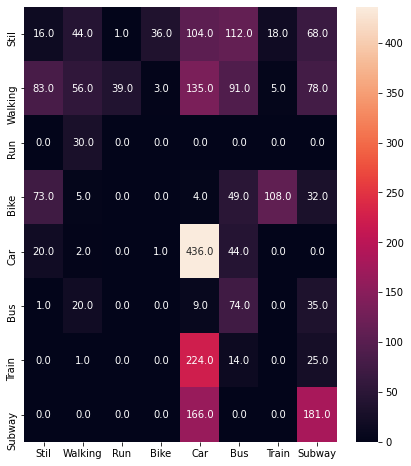

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in ['Stil','Walking','Run','Bike', 'Car', 'Bus', 'Train','Subway']],
                  columns = [i for i in ['Stil','Walking','Run','Bike', 'Car', 'Bus', 'Train','Subway']])
plt.figure(figsize = (7,8))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
sn.heatmap(df_cm, annot=True,fmt=".1f")
plt.savefig(fname="confusion matrix-WIFI.png",dpi=600)

# XGBoost Classifier

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
clf=xgb.XGBClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

0.29553827261563653
              precision    recall  f1-score   support

         1.0       0.31      0.08      0.13       399
         2.0       0.22      0.07      0.11       490
         3.0       0.00      0.00      0.00        30
         4.0       0.42      0.56      0.48       271
         5.0       0.32      1.00      0.48       503
         6.0       0.00      0.00      0.00       139
         7.0       0.00      0.00      0.00       264
         8.0       0.00      0.00      0.00       347

    accuracy                           0.30      2443
   macro avg       0.16      0.21      0.15      2443
weighted avg       0.21      0.30      0.20      2443



#Decision Tress Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf= DecisionTreeClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

0.2762996316004912
              precision    recall  f1-score   support

         1.0       0.11      0.04      0.06       399
         2.0       0.21      0.28      0.24       490
         3.0       0.00      0.00      0.00        30
         4.0       0.01      0.01      0.01       271
         5.0       0.33      0.68      0.44       503
         6.0       0.00      0.00      0.00       139
         7.0       0.00      0.00      0.00       264
         8.0       0.80      0.52      0.63       347

    accuracy                           0.28      2443
   macro avg       0.18      0.19      0.17      2443
weighted avg       0.24      0.28      0.24      2443



# Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf= ExtraTreesClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

0.2885796152271797
              precision    recall  f1-score   support

         1.0       0.10      0.03      0.04       399
         2.0       0.23      0.16      0.19       490
         3.0       0.00      0.00      0.00        30
         4.0       0.03      0.01      0.01       271
         5.0       0.43      0.82      0.56       503
         6.0       0.01      0.01      0.01       139
         7.0       0.10      0.07      0.08       264
         8.0       0.37      0.52      0.43       347

    accuracy                           0.29      2443
   macro avg       0.16      0.20      0.17      2443
weighted avg       0.22      0.29      0.23      2443



# AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf= AdaBoostClassifier(n_estimators=100)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

0.07449856733524356
              precision    recall  f1-score   support

         1.0       0.19      0.24      0.22       399
         2.0       0.13      0.01      0.02       490
         3.0       0.00      0.00      0.00        30
         4.0       0.09      0.24      0.13       271
         5.0       0.00      0.00      0.00       503
         6.0       0.05      0.11      0.07       139
         7.0       0.00      0.00      0.00       264
         8.0       0.00      0.00      0.00       347

    accuracy                           0.07      2443
   macro avg       0.06      0.08      0.05      2443
weighted avg       0.07      0.07      0.06      2443



#CatBoost Classifier

In [ ]:
!pip3 install catboost
from catboost import CatBoostClassifier
clf= CatBoostClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_val)

     |████████████████████████████████| 67.3MB 59kB/s 
Learning rate set to 0.094448
0:	learn: 1.9938557	total: 341ms	remaining: 5m 40s
1:	learn: 1.9263569	total: 482ms	remaining: 4m
2:	learn: 1.8824031	total: 606ms	remaining: 3m 21s
3:	learn: 1.8356271	total: 733ms	remaining: 3m 2s
4:	learn: 1.7989076	total: 860ms	remaining: 2m 51s
5:	learn: 1.7600469	total: 989ms	remaining: 2m 43s
6:	learn: 1.7325129	total: 1.11s	remaining: 2m 38s
7:	learn: 1.7106597	total: 1.24s	remaining: 2m 33s
8:	learn: 1.6872456	total: 1.37s	remaining: 2m 31s
9:	learn: 1.6657864	total: 1.49s	remaining: 2m 27s
10:	learn: 1.6431359	total: 1.61s	remaining: 2m 24s
11:	learn: 1.6263440	total: 1.72s	remaining: 2m 21s
12:	learn: 1.6083064	total: 1.87s	remaining: 2m 21s
13:	learn: 1.5928531	total: 2s	remaining: 2m 20s
14:	learn: 1.5768591	total: 2.11s	remaining: 2m 18s
15:	learn: 1.5604103	total: 2.22s	remaining: 2m 16s
16:	learn: 1.5429506	total: 2.35s	remaining: 2m 15s
17:	learn: 1.5357904	total: 2.46s	remaining: 2m 1

In [ ]:
print(accuracy_score(y_val,y_pred))
print(metrics.classification_report(y_val, y_pred))

0.28448628735161685
              precision    recall  f1-score   support

         1.0       0.35      0.14      0.20       399
         2.0       0.15      0.13      0.14       490
         3.0       0.00      0.00      0.00        30
         4.0       0.27      0.18      0.22       271
         5.0       0.35      1.00      0.52       503
         6.0       0.00      0.00      0.00       139
         7.0       0.00      0.00      0.00       264
         8.0       0.17      0.07      0.09       347

    accuracy                           0.28      2443
   macro avg       0.16      0.19      0.15      2443
weighted avg       0.21      0.28      0.21      2443



# Test

In [ ]:
path_test = '/content/drive/MyDrive/SHL 2021/Test/WiFi/WiFi- gonna give label.csv'
fe3 = feature_extraction(path_test, window_len=30, overlap=0,up=0)
features = fe3.extract(labelled=False)

In [ ]:
df_test = pd.DataFrame(features)
column_names='time_min time_max time_std time_avg time_var \
              N \
              F1_min F1_mam F1_std F1_avg F1_var F1_ptp F1_mrc F1_arc F1_src F1_mad F1_iqr F1_cor F1_rms F1_vel \
              F2_min F2_mam F2_std F2_avg F2_var F2_ptp F2_mrc F2_arc F2_src F2_mad F2_iqr F2_cor F2_rms F2_vel \
              F3_min F3_mam F3_std F3_avg F3_var F3_ptp F3_mrc F3_arc F3_src F3_mad F3_iqr F3_cor F3_rms F3_vel \
              F4_min F4_mam F4_std F4_avg F4_var F4_ptp F4_mrc F4_arc F4_src F4_mad F4_iqr F4_cor F4_rms F4_vel \
              F5_min F5_mam F5_std F5_avg F5_var F5_ptp F5_mrc F5_arc F5_src F5_mad F5_iqr F5_cor F5_rms F5_vel \
              F6_min F6_mam F6_std F6_avg F6_var F6_ptp F6_mrc F6_arc F6_src F6_mad F6_iqr F6_cor F6_rms F6_vel \
              F7_min F7_mam F7_std F7_avg F7_var F7_ptp F7_mrc F7_arc F7_src F7_mad F7_iqr F7_cor F7_rms F7_vel \
              F8_min F8_mam F8_std F8_avg F8_var F8_ptp F8_mrc F8_arc F8_src F8_mad F8_iqr F8_cor F8_rms F8_vel \'
              
df_test.columns = column_names.split()
df_test.fillna(0,inplace=True)

In [ ]:
df_test.columns[df_test.isnull().any()]

In [ ]:
x_test=df_test.values
y_pred=clf1.predict(x_test)

# Final Prediction

In [ ]:
y_pred_ext=[]
for i in range(len(y_pred)):
  for j in range(30):
    y_pred_ext.append(y_pred[i])

import collections
elements_count = collections.Counter(y_pred)
for key, value in elements_count.items():
   print(f"{key}: {value}") 

In [ ]:
b=len(wifi_test)-len(y_pred_ext)
print(b)
for i in range(0,b):
  y_pred_ext.append(1)

prediction=list(y_pred_ext)
print('prediction length:    ',len(prediction))
print('wifi test length:     ',len(wifi_test))  

In [ ]:
from pandas import DataFrame
wifi_prediction=DataFrame(prediction,columns=['WiFi_Prediction'])
wifi_prediction.to_csv("/content/drive/MyDrive/SHL 2021/Test/Label/WiFi_Prediction.csv")